In [1]:
import numpy as np
import torch
%matplotlib widget
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from learn_embedding.approximators import *
from learn_embedding.covariances import *
from learn_embedding.kernels import SquaredExp
from learn_embedding.embedding import Embedding
from learn_embedding.dynamics import SecondGeometry, LinearField
from learn_embedding.utils import *

## Torch Configuration

In [2]:
use_cuda = False # torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

## Create Model

In [3]:
dim = 2
# approximator = KernelExpansion(train_x)
# approximator = KernelMachine(dim, 1000, 1, length=0.4)
approximator = FeedForward(dim, [64], 1)

embedding = Embedding(approximator)
TorchHelper.set_zero(embedding)

stiffness = Spherical(1, False)
dissipation = Spherical(2, False)

attractor = torch.tensor([0.0,0.0]).to(device)

field = LinearField(attractor, Spherical(0.5, False))

model = SecondGeometry(embedding, attractor, stiffness, dissipation).to(device)
model.velocity_embedding = True

## Test

In [4]:
resolution = 100
min_ax = torch.tensor([-1,-1])
max_ax = torch.tensor([1,1])
x, y = torch.meshgrid(torch.linspace(min_ax[0], max_ax[0], resolution), torch.linspace(min_ax[1], max_ax[1], resolution), indexing='xy')

grid_x = torch.stack((torch.ravel(x), torch.ravel(y)), dim=1).to(device).requires_grad_(True)
grid_v = torch.zeros_like(grid_x).to(device).requires_grad_(True)

grid_xr = torch.stack((torch.ravel(x[10::10,10::10]), torch.ravel(y[10::10,10::10])), dim=1).to(device).requires_grad_(True)
grid_vr = torch.zeros_like(grid_xr).to(device).requires_grad_(True)

theta = torch.linspace(0, 2*torch.pi, steps=50).to(device)

### Potential

In [5]:
potential = model.potential(grid_x).reshape(resolution, -1).cpu().detach().numpy()

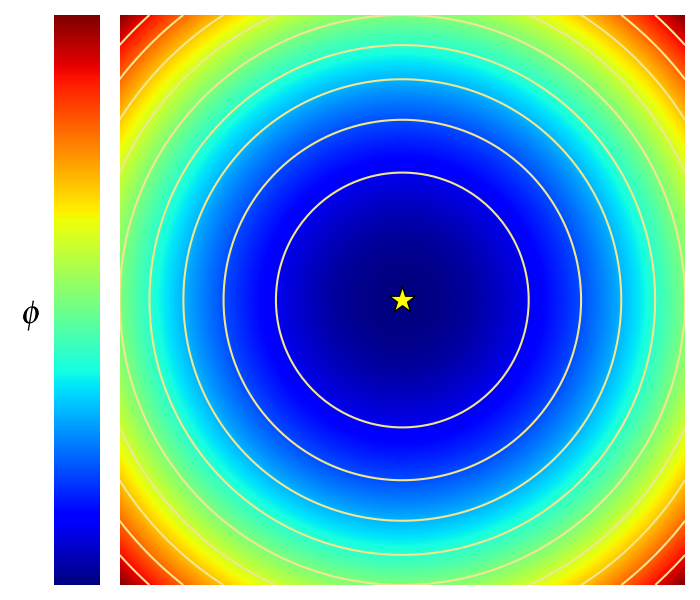

In [6]:
# Enable LaTeX rendering
plt.rcParams['text.usetex'] = True

# Set Times as the font family
plt.rcParams['font.family'] = 'Times'

fig, ax = plt.subplots(figsize=(7, 6))

im = ax.contourf(x, y, potential, 500, cmap="jet")
ax.contour(x, y, potential, 10, cmap=None, colors='#f2e68f')
ax.scatter(attractor[0].cpu(), attractor[1].cpu(), s=400, edgecolors='k', c='yellow', marker="*", zorder=20)

divider = make_axes_locatable(ax)
cax = divider.append_axes("left", size="8%", pad=0.2)
cax.yaxis.set_label_position("left")
norm = plt.Normalize(vmin=potential.min(), vmax=potential.max())
colors = plt.cm.jet(norm(potential))
mappable = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=norm)
cbar = fig.colorbar(mappable, cax=cax)
cbar.outline.set_visible(False)
cbar.ax.tick_params(size=0)
cbar.set_ticks([])
cbar.set_label('$\phi$', fontsize=24, rotation=0, labelpad=-50)

ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

# ax.set_xlabel('$q_1$', fontsize=24)
# ax.set_ylabel('$q_2$', fontsize=24, rotation=0, labelpad=20)

ax.set_xticks([])
ax.set_yticks([])

# Adjust layout
fig.tight_layout()

fig.savefig('../outputs/local_potential_second.png', format='png', dpi=300, bbox_inches="tight")

### Vector Field & Streamlines

In [16]:
obstacle_radius = 0.1 # 0.05 , 0.1
obstacle = torch.tensor([[-0.4,-0.4]])
# obstacle = Obstacles.square(center=torch.tensor([-30,20]), a=20, b=20, res=10)
# obstacle = Obstacles.semi_circle(radius=0.2, center=torch.tensor([-0.4,   -0.4]), rot=torch.tensor(torch.pi/4), res=50)
decay = 5e-1
lengthscale = np.sqrt(-0.5*obstacle_radius**2/np.log(decay))
# phi = KernelExpansion(obstacle.to(device), kernel=SquaredExp(l=lengthscale)).to(device)
phi = KernelDeformation(obstacle.to(device), weights = 10.0*torch.ones(obstacle.shape[0]).to(device), kernel=SquaredExp(l=lengthscale), tol=-0.05).to(device)
embedding.local_deformation = phi

field = model(torch.cat((grid_x,grid_v),dim=1))
x_field = field[:, 0].reshape(resolution, -1).cpu().detach().numpy()
y_field = field[:, 1].reshape(resolution, -1).cpu().detach().numpy()

x0 = torch.tensor([[-0.9, -0.80, 1, 1]]).to(device).requires_grad_(True)
streamlines = Integrator.second_order(dynamics=model,x0=x0,T=6.0, dt=0.01).cpu().detach().numpy()
geodesic = Integrator.second_order(dynamics=model.geodesic,x0=x0,T=3.0, dt=0.01).cpu().detach().numpy()

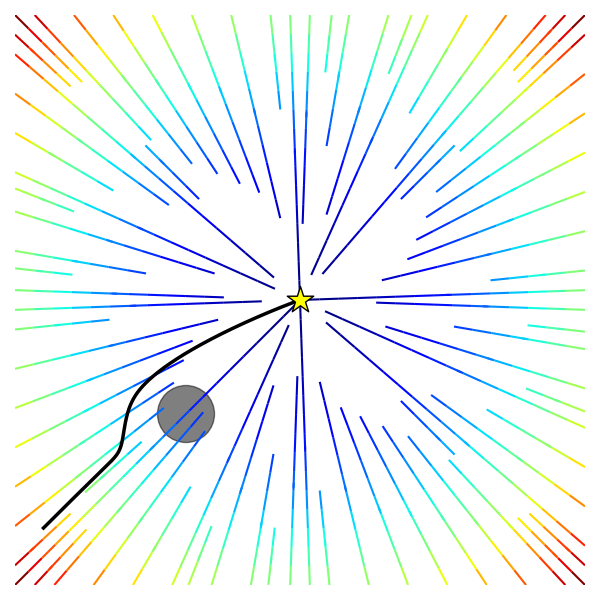

In [17]:
# Enable LaTeX rendering
plt.rcParams['text.usetex'] = True

# Set Times as the font family
plt.rcParams['font.family'] = 'Times'

fig, ax = plt.subplots(figsize=(6, 6))

steps = 20
ax.streamplot(x.numpy(), y.numpy(), x_field, y_field, color=potential, cmap="jet", linewidth=1.5, arrowstyle='-', arrowsize=1.5)
ax.scatter(attractor[0].cpu(), attractor[1].cpu(), s=400, edgecolors='k', c='yellow', marker="*", zorder=10)

for i in range(streamlines.shape[1]):
    ax.plot(streamlines[:, i, 0], streamlines[:, i, 1], color='k', linewidth=2.5)
#     ax.plot(geodesic[:, i, 0], geodesic[:, i, 1], color='k', linestyle='dashed', linewidth=2.5)

if hasattr(embedding, 'local_deformation'):
    for i in range(0,obstacle.shape[0],4):
        circ = plt.Circle((obstacle[i, 0], obstacle[i, 1]), obstacle_radius,
                            color='k', fill='grey', alpha=0.5)
        ax.add_patch(circ)
# divider = make_axes_locatable(ax)
# cax = divider.append_axes("left", size="8%", pad=0.2)
# cax.yaxis.set_label_position("left")
# norm = plt.Normalize(vmin=potential.min(), vmax=potential.max())
# colors = plt.cm.jet(norm(potential))
# mappable = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=norm)
# cbar = fig.colorbar(mappable, cax=cax)
# cbar.outline.set_visible(False)
# cbar.ax.tick_params(size=0)
# cbar.set_ticks([])
# cbar.set_label('$\phi$', fontsize=24, rotation=0, labelpad=-50)

ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

# ax.set_xlabel('$q_1$', fontsize=24)
# ax.set_ylabel('$q_2$', fontsize=24, rotation=0, labelpad=20)

ax.set_xticks([])
ax.set_yticks([])

ax.set_xlim([min_ax[0].cpu(), max_ax[0].cpu()])
ax.set_ylim([min_ax[1].cpu(), max_ax[1].cpu()])

# Adjust layout
fig.tight_layout()
fig.savefig('../outputs/local_field_second.png', format='png', dpi=300, bbox_inches="tight")

### Embedding

In [9]:
grid_embedding = embedding(grid_x)
x_embedding = grid_embedding[:, 0].reshape(resolution, -1).cpu().detach().numpy()
y_embedding = grid_embedding[:, 1].reshape(resolution, -1).cpu().detach().numpy()
z_embedding = grid_embedding[:, 2].reshape(resolution, -1).cpu().detach().numpy()

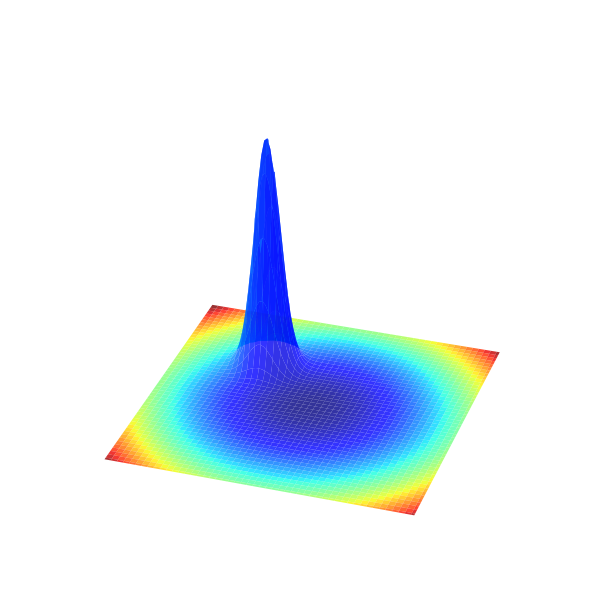

In [10]:
# Enable LaTeX rendering
plt.rcParams['text.usetex'] = True

# Set Times as the font family
plt.rcParams['font.family'] = 'Times'

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection="3d", computed_zorder=False)

norm = plt.Normalize(vmin=potential.min(), vmax=potential.max())
colors = plt.cm.jet(norm(potential))
im = ax.plot_surface(x_embedding, y_embedding, z_embedding, cmap='jet', edgecolor='none', antialiased=True, alpha=0.8, facecolors=colors)

ax.set_xlabel('$y^1$')
ax.set_ylabel('$y^2$')
ax.set_zlabel('$y^3$')

# Adjust plot limits, if necessary
# ax.set_xlim(x_min, x_max)
# ax.set_ylim(y_min, y_max)
# ax.set_zlim(z_min, z_max)

ax.axis('off')

ax.view_init(elev=30, azim=18)  # Adjust the elevation (up/down) and azimuth (left/right) an

# # Add colorbar without ticks and labels
# mappable = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=norm)
# cbar = fig.colorbar(mappable, ax=ax, shrink=0.5, aspect=10)
# cbar.set_label('$\phi$', fontsize=24, rotation=0, labelpad=10)

# cbar.ax.set_yticklabels([])
# cbar.ax.tick_params(length=0)
# cbar.outline.set_visible(False)  # Remove colorbar frame

# # Shrink colorbar to dimensions of the plot
# cbar.ax.set_position([0.52, 0.1, 0.03, 0.8])  # Adjust colorbar position and width

# Adjust layout
fig.tight_layout()
fig.savefig('../outputs/local_embedding_second.png', format='png', dpi=300, bbox_inches="tight")

### Metric

In [11]:
metric = model.embedding.pullmetric(grid_embedding, model.embedding.jacobian(grid_x, grid_embedding))
det_metric = metric.det().reshape(resolution, -1).detach().cpu().numpy()

red_embedding = embedding(grid_xr)
metric_r = embedding.pullmetric(red_embedding, embedding.jacobian(grid_xr, red_embedding))
evals,evecs = torch.linalg.eigh(metric_r)

ellipses = torch.stack((evals[:, 0].unsqueeze(-1)*theta.cos(), evals[:, 1].unsqueeze(-1)*theta.sin()), dim=2)
ellipses = torch.bmm(evecs, ellipses.permute(0, 2, 1)).permute(0, 2, 1).detach().cpu()/10
ellipses_x = x[10::10,10::10].ravel().unsqueeze(-1) + ellipses[:, :, 0]
ellipses_y = y[10::10,10::10].ravel().unsqueeze(-1) + ellipses[:, :, 1]

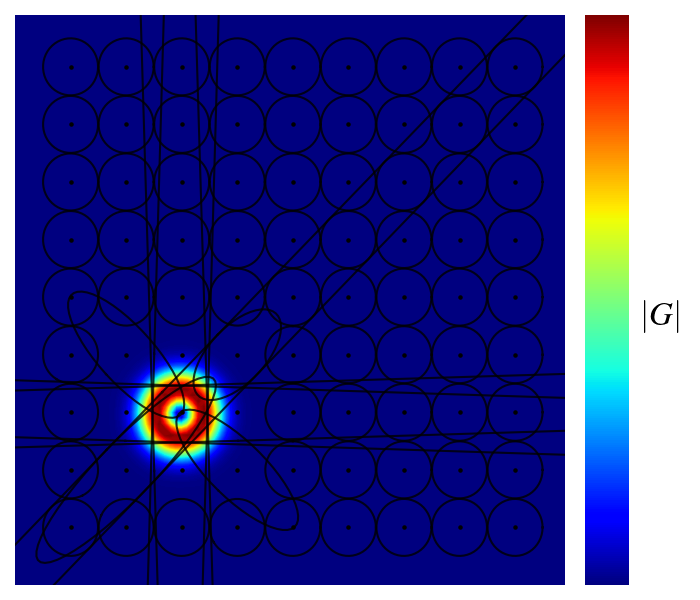

In [12]:
# Enable LaTeX rendering
plt.rcParams['text.usetex'] = True

# Set Times as the font family
plt.rcParams['font.family'] = 'Times'

# Create the figure and axes
fig, ax = plt.subplots(figsize=(7, 6))

# Plot the filled contour
contour = ax.contourf(x, y, det_metric, 500, cmap="jet")

# Plot scattered points
ax.scatter(x[10::10, 10::10], y[10::10, 10::10], color="k", s=5)

# Plot ellipses
for i in range(ellipses.shape[0]):
    ax.plot(ellipses_x[i, :], ellipses_y[i, :], color="k", linewidth=1.5, alpha=0.8)

# Add colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="8%", pad=0.2)
cax.yaxis.set_label_position("right")
norm = plt.Normalize(vmin=det_metric.min(), vmax=det_metric.max())
colors = plt.cm.jet(norm(det_metric))
mappable = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=norm)
cbar = fig.colorbar(mappable, cax=cax)
cbar.outline.set_visible(False)
cbar.ax.tick_params(size=0)
cbar.set_ticks([])
cbar.set_label(r'$|G|$', fontsize=24, rotation=0, labelpad=25)

# Set labels and tick sizes
# ax.set_xlabel('$q_1$', fontsize=24)
# ax.set_ylabel('$q_2$', fontsize=24, rotation=0, labelpad=20)
# ax.tick_params(axis='both', which='major', labelsize=16)

# Set axis limits
ax.set_xlim([min_ax[0].cpu(), max_ax[0].cpu()])
ax.set_ylim([min_ax[1].cpu(), max_ax[1].cpu()])

# Hide spines
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

# Remove ticks
ax.set_xticks([])
ax.set_yticks([])

# Improve plot layout
fig.tight_layout()

# Adjust layout
fig.tight_layout()
fig.savefig('../outputs/local_detmetric_second.png', format='png', dpi=300, bbox_inches="tight")

### Inverse Metric Ellispses on Streamlines

In [13]:
step = 20
trajectory = geodesic # streamlines
x_sampled = torch.from_numpy(trajectory[:, 0, :dim]).float().to(device).requires_grad_(True)
v_sampled = torch.from_numpy(trajectory[:, 0, dim:]).float().to(device).requires_grad_(True)
sampled_embedding = embedding(x_sampled)

metric_sampled = model.embedding.pullmetric(sampled_embedding, model.embedding.jacobian(x_sampled, sampled_embedding))
metric_evals,metric_evecs = torch.linalg.eigh(metric_sampled.inverse())

x_range = (max_ax[0] - min_ax[0]).abs()
y_range = (max_ax[1] - min_ax[1]).abs()
metric_evals /= 10*torch.tensor([y_range/x_range,1.0]).to(device)

metric_ellipses = torch.stack((metric_evals[:, 0].unsqueeze(-1)*theta.cos(), metric_evals[:, 1].unsqueeze(-1)*theta.sin()), dim=2)
metric_ellipses = torch.bmm(metric_evecs, metric_ellipses.permute(0, 2, 1)).permute(0, 2, 1).detach().cpu()

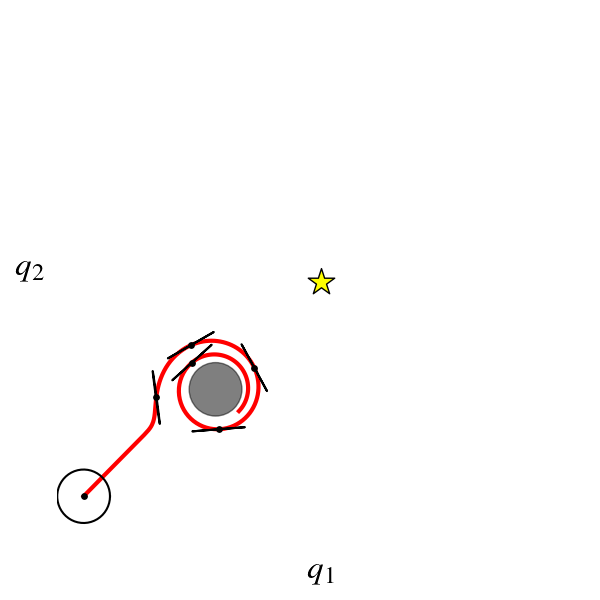

In [14]:
# Enable LaTeX rendering
plt.rcParams['text.usetex'] = True

# Set Times as the font family
plt.rcParams['font.family'] = 'Times'

fig, ax = plt.subplots(figsize=(6, 6))

step = 50
ax.plot(x_sampled[:, 0].detach().cpu(), x_sampled[:, 1].detach().cpu(), color='r', linewidth='3')

ax.scatter(x_sampled[::step, 0].detach().cpu(), x_sampled[::step, 1].detach().cpu(), color="k", s=15, zorder=10)

for i in range(0, metric_ellipses.shape[0], step):
    ax.plot(x_sampled[i, 0].detach().cpu() + metric_ellipses[i, :, 0],
            x_sampled[i, 1].detach().cpu() + metric_ellipses[i, :, 1], color="k", linewidth=1.5)
    
ax.scatter(attractor[0].cpu(), attractor[1].cpu(), s=400, edgecolors='k', c='yellow', marker="*", zorder=20)

if hasattr(embedding, 'local_deformation'):
    for i in range(obstacle.shape[0]):
        circ = plt.Circle((obstacle[i, 0], obstacle[i, 1]), obstacle_radius,
                            color='k', fill='grey', alpha=0.5)
        ax.add_patch(circ)
# Set labels and tick sizes
ax.set_xlabel('$q_1$', fontsize=24)
ax.set_ylabel('$q_2$', fontsize=24, rotation=0, labelpad=20)
# ax.tick_params(axis='both', which='major', labelsize=16)

# Set axis limits
ax.set_xlim([min_ax[0].cpu(), max_ax[0].cpu()])
ax.set_ylim([min_ax[1].cpu(), max_ax[1].cpu()])

# Hide spines
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

# Remove ticks
ax.set_xticks([])
ax.set_yticks([])

# Improve plot layout
fig.tight_layout()

fig.savefig('../outputs/local_metric_second.png', format='png', dpi=300, bbox_inches="tight")

### Christoffel Symbols

In [15]:
christoffel_sampled = embedding.christoffel(x_sampled, metric_sampled)
christoffel_sampled = torch.einsum('bqij,bi->bqj', christoffel_sampled, v_sampled)
christoffel_evals,christoffel_evecs = torch.linalg.eig(christoffel_sampled)
christoffel_evals = torch.real(christoffel_evals)
christoffel_evecs = torch.real(christoffel_evecs)
christoffel_ellipses = torch.stack((christoffel_evals[:, 0].unsqueeze(-1)*theta.cos(), christoffel_evals[:, 1].unsqueeze(-1)*theta.sin()), dim=2)
christoffel_ellipses = torch.bmm(christoffel_evecs, christoffel_ellipses.permute(0, 2, 1)).permute(0, 2, 1).detach().cpu()/eval_scale

NameError: name 'eval_scale' is not defined

In [ ]:
# Enable LaTeX rendering
plt.rcParams['text.usetex'] = True

# Set Times as the font family
plt.rcParams['font.family'] = 'Times'

fig, ax = plt.subplots(figsize=(6, 6))

step = 50
ax.plot(x_sampled[:, 0].detach().cpu(), x_sampled[:, 1].detach().cpu(), color='r', linewidth='3')

ax.scatter(x_sampled[::step, 0].detach().cpu(), x_sampled[::step, 1].detach().cpu(), color="k", s=15, zorder=10)

for i in range(0,christoffel_ellipses.shape[0],step):
    ax.plot(x_sampled[i, 0].detach().cpu() + christoffel_ellipses[i, :, 0],
            x_sampled[i, 1].detach().cpu() + christoffel_ellipses[i, :, 1], color="k", linewidth=1.5)
    
ax.scatter(attractor[0].cpu(), attractor[1].cpu(), s=400, edgecolors='k', c='yellow', marker="*", zorder=20)

if hasattr(embedding, 'local_deformation'):
    for i in range(obstacle.shape[0]):
        circ = plt.Circle((obstacle[i, 0], obstacle[i, 1]), obstacle_radius,
                            color='k', fill='grey', alpha=0.5)
        ax.add_patch(circ)
        
# Set labels and tick sizes
ax.set_xlabel('$q_1$', fontsize=24)
ax.set_ylabel('$q_2$', fontsize=24, rotation=0, labelpad=20)
# ax.tick_params(axis='both', which='major', labelsize=16)

# Set axis limits
ax.set_xlim([min_ax[0].cpu(), max_ax[0].cpu()])
ax.set_ylim([min_ax[1].cpu(), max_ax[1].cpu()])

# Hide spines
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

# Remove ticks
ax.set_xticks([])
ax.set_yticks([])

# Improve plot layout
fig.tight_layout()

fig.savefig('../outputs/local_christoffel_second.png', format='png', dpi=300, bbox_inches="tight")